In [1]:
#import libraries
import os
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Input, concatenate, Flatten, Dense, Attention, Multiply, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

2024-04-08 21:03:48.321265: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# import zipfile

# f = zipfile.ZipFile("B_dataset.zip",'r') # 压缩文件在jupyter中的位置
# for file in f.namelist():
#     f.extract(file,"")               # 解压到的位置
# f.close()

In [3]:
# Data preparation
dataset_dir= 'B_split'
input_shape=(224, 224, 3)
batch_size=8
num_classes=2

In [4]:
#Data augmentation
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen=ImageDataGenerator(
    rescale=1./255)

In [5]:
# # 定义主目录和子目录
# main_dir = "B_dataset"
# train_dir = 'train'
# test_dir = 'test'
# val_dir = 'val'

In [6]:
# # 创建目录
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)

In [7]:
# # 定义划分比例
# train_ratio = 0.7
# test_ratio = 0.2
# val_ratio = 0.1

In [8]:
# import random
# import shutil
# # 遍历主目录下的子目录（类别）
# for subdir in os.listdir(main_dir):
#     subdir_path = os.path.join(main_dir, subdir)
#     if os.path.isdir(subdir_path):
#         # 创建类别对应的目录
#         os.makedirs(os.path.join(train_dir, subdir), exist_ok=True)
#         os.makedirs(os.path.join(test_dir, subdir), exist_ok=True)
#         os.makedirs(os.path.join(val_dir, subdir), exist_ok=True)
        
#         # 获取类别下的所有图像文件
#         images = [f for f in os.listdir(subdir_path) if f.endswith('.jpg') or f.endswith('.png')]
#         num_images = len(images)
        
#         # 随机打乱图像文件列表
#         random.shuffle(images)
        
#         # 计算划分数量
#         train_split = int(train_ratio * num_images)
#         test_split = int(test_ratio * num_images)
        
#         # 划分图像文件并拷贝到对应目录
#         train_images = images[:train_split]
#         test_images = images[train_split:train_split + test_split]
#         val_images = images[train_split + test_split:]
        
#         for img in train_images:
#             src = os.path.join(subdir_path, img)
#             dst = os.path.join(train_dir, subdir, img)
#             shutil.copyfile(src, dst)
            
#         for img in test_images:
#             src = os.path.join(subdir_path, img)
#             dst = os.path.join(test_dir, subdir, img)
#             shutil.copyfile(src, dst)
            
#         for img in val_images:
#             src = os.path.join(subdir_path, img)
#             dst = os.path.join(val_dir, subdir, img)
#             shutil.copyfile(src, dst)


In [9]:
# #Generate the train dataset, validation dataset and test dataset
train_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',)

validation_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'val'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    )

test_generator=test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary' 
)

Found 2563 images belonging to 2 classes.
Found 368 images belonging to 2 classes.
Found 732 images belonging to 2 classes.


In [10]:
#Ensemble Model using pre-trained model

# Load pre-trained models
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the pre-trained models
for layer in resnet_model.layers:
    layer.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

2024-04-08 21:03:56.785700: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-04-08 21:03:56.863627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:e3:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.55GHz coreCount: 128 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 938.86GiB/s
2024-04-08 21:03:56.863682: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-04-08 21:03:56.868755: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-04-08 21:03:56.868896: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-04-08 21:03:56.870475: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

In [11]:
# 假设 resnet_model 和 vgg_model 是你的预训练模型

input_layer = Input(shape=(224, 224, 3))
resnet_features = resnet_model(input_layer)
vgg_features = vgg_model(input_layer)

merged = concatenate([resnet_features, vgg_features])
flatten = Flatten()(merged)
dense1 = Dense(512, activation='relu')(flatten)
output_layer = Dense(1, activation='sigmoid')(dense1)

ensemble_model = Model(inputs=input_layer, outputs=output_layer)


ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 7, 7, 2048)   23587712    input_3[0][0]                    
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 7, 7, 512)    14714688    input_3[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 7, 7, 2560)   0           resnet50[0][0]                   
                                                                 vgg16[0][0]                  

In [12]:
# Compile and train the ensemble model
ensemble_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
#Train the model
history=ensemble_model.fit(train_generator, batch_size=batch_size, epochs=50, validation_data=(validation_generator), verbose=1)

Epoch 1/50
321/321 [==============================] - 47s 146ms/step - loss: 0.1463 - accuracy: 0.9497 - val_loss: 0.2678 - val_accuracy: 0.9239
Epoch 2/50
321/321 [==============================] - 47s 146ms/step - loss: 0.1551 - accuracy: 0.9469 - val_loss: 0.3021 - val_accuracy: 0.9076
Epoch 3/50
321/321 [==============================] - 47s 147ms/step - loss: 0.1487 - accuracy: 0.9501 - val_loss: 0.2306 - val_accuracy: 0.9266
Epoch 4/50
321/321 [==============================] - 47s 148ms/step - loss: 0.1550 - accuracy: 0.9450 - val_loss: 0.3385 - val_accuracy: 0.8913
Epoch 5/50
321/321 [==============================] - 50s 156ms/step - loss: 0.1647 - accuracy: 0.9462 - val_loss: 0.2649 - val_accuracy: 0.9158
Epoch 6/50
321/321 [==============================] - 54s 169ms/step - loss: 0.1398 - accuracy: 0.9555 - val_loss: 0.2196 - val_accuracy: 0.9266
Epoch 7/50
321/321 [==============================] - 52s 162ms/step - loss: 0.1538 - accuracy: 0.9458 - val_loss: 0.2818 - val_ac

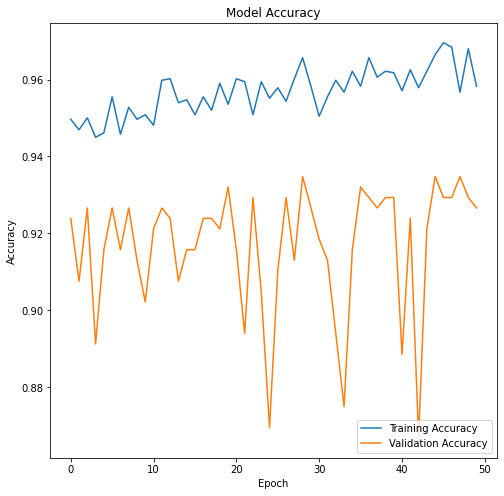

In [31]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')
plt.show()

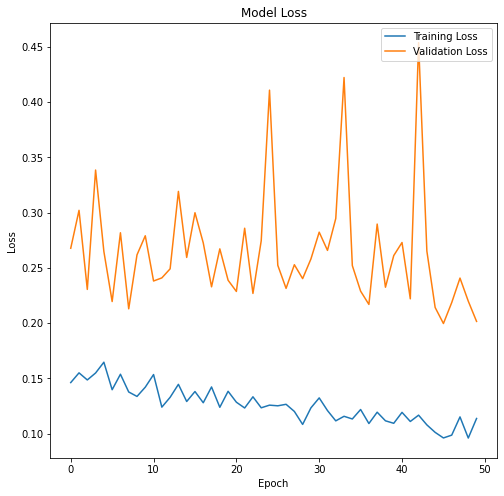

In [32]:
#Trainig loss and validation loss graph
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')
plt.show()

In [33]:
# Evaluate the model on the testing dataset
test_loss, test_acc = ensemble_model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

92/92 [==============================] - 5s 49ms/step - loss: 0.1899 - accuracy: 0.9454
Test loss: 0.1898958384990692
Test accuracy: 0.9453551769256592


In [34]:
#Compute confusion matrix
from sklearn.metrics import confusion_matrix

# Generate predictions for the test dataset
y_pred = ensemble_model.predict(test_generator)

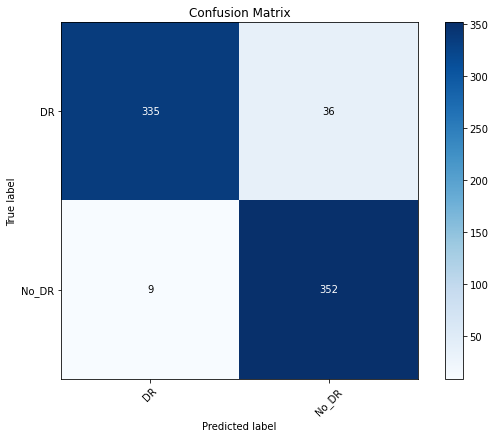

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['DR', 'No_DR'], rotation=45)
plt.yticks(tick_marks, ['DR', 'No_DR'])

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 使用阈值0.5将概率值转换为二分类预测结果
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

# 获取真实标签
y_true = test_generator.classes

# 计算精确度、召回率和F1得分
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.9234828496042217
Recall: 0.9695290858725761
F1 Score: 0.9459459459459459


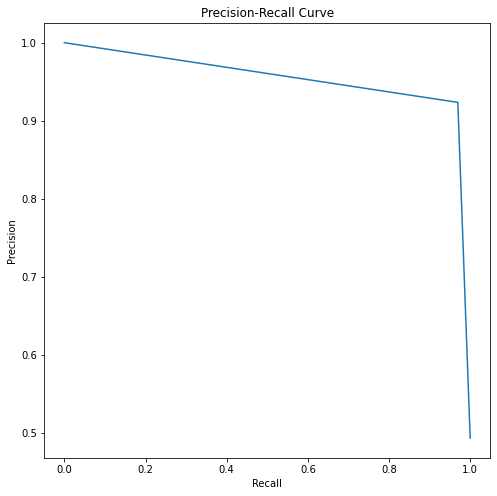

In [37]:
#compute precision-recall score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

#compute precision, recall(sensitivity), and threshold values
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_binary)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [38]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred_binary)

#compute the AUC score
roc_auc= auc(fpr, tpr)

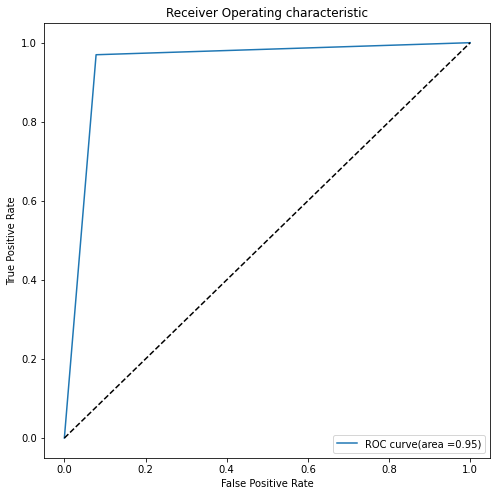

In [39]:
#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [40]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 0.9695290858725761
specificity: 0.921832884097035


In [24]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

del ensemble_model

In [25]:
#You need to install numba using 'pip install numba'

from numba import cuda

cuda.select_device(0)
cuda.close()

ModuleNotFoundError: No module named 'numba'